In [1]:
# Google Drive setup
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import os

def load_coco_dataset(data_dir, annotation_file) -> list:
    # Initialize COCO api for instance annotations
    coco = COCO(annotation_file)

    # Load categories
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)
    cat_names = [cat['name'] for cat in cats]
    cat_name_to_id = {cat['name']: cat['id'] for cat in cats}
    # print(cat_name_to_id)

    # Load image ids
    img_ids = coco.getImgIds()
    # print(img_ids)

    images = []
    masks = []

    for img_id in img_ids:
        # Load image
        img_info = coco.loadImgs(img_id)[0]
        img_path = f"{data_dir}/{img_info['file_name']}"
        image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load annotations for the image
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        masks_image = []
        for ann in anns:
            mask = generate_mask(ann['segmentation'][0], (img_info['height'], img_info['width']))
            masks_image.append(mask)

        final_image_mask = add_up_masks(masks_image, (img_info['height'], img_info['width']))
        final_image_mask = convert_grayscale_to_RGB(final_image_mask)
        # print(type(final_image_mask))
        final_image_mask = create_pink_contours(final_image_mask)

        images.append(image)
        masks.append(final_image_mask)

    return images, masks, cat_name_to_id

def add_up_masks(masks_image, image_shape) -> np.array:
  merged_mask = np.zeros(image_shape[:2], dtype=np.uint8)
  for mask in masks_image:
      merged_mask = cv2.add(merged_mask, mask)

  return merged_mask

def generate_mask(points, image_shape) -> np.array:
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    pts = np.array(points, np.int32)
    pts = pts.reshape((-1, 2))
    cv2.fillPoly(mask, [pts], color=(255))

    return mask

def convert_grayscale_to_RGB(grayscale_image: np.array) -> np.array:
  grayscale_image = np.expand_dims(grayscale_image, axis=-1)
  # Expand the grayscale channel to create a 3-channel image
  rgb_image = np.repeat(grayscale_image, 3, axis=2)
  # plt.imshow(rgb_image)
  # plt.show()
  return rgb_image

def create_pink_contours(image: np.array) -> np.array:
  pink_color_RGB_structures = (195, 75, 182)

  indices = np.where(image == 0)
  image[indices[0], indices[1], :] = pink_color_RGB_structures

  return image

In [3]:
!pwd

/content


Annotations in .json format obtained via https://www.makesense.ai/

In [4]:
!mkdir images
path_dataset = '/content/gdrive/MyDrive/ECM_data/dataset.zip'
!unzip {path_dataset} -d ./images

# path_json = '/content/gdrive/MyDrive/ECM_data/trainval_more_anns.json'
path_json = '/content/gdrive/MyDrive/ECM_data/trainval_more_anns_white_places_anns.json'
!cp {path_json} -d ./

Výstupní stream byl oříznut na posledních 5000 řádků.
  inflating: ./images/cnjkuxwp.png   
  inflating: ./images/73cybz20.png   
  inflating: ./images/05unsoa7.png   
  inflating: ./images/boanrs96.png   
  inflating: ./images/ho2j1ewu.png   
  inflating: ./images/iogvkid8.png   
  inflating: ./images/9i95ee3k.png   
  inflating: ./images/s9l12g87.png   
  inflating: ./images/zlnn7t7m.png   
  inflating: ./images/ri660uxs.png   
  inflating: ./images/0r6s7tbx.png   
  inflating: ./images/4xh2pf66.png   
  inflating: ./images/kyp5qe1e.png   
  inflating: ./images/xndhwnof.png   
  inflating: ./images/bds146xk.png   
  inflating: ./images/u8j4x92u.png   
  inflating: ./images/4d0qeqdo.png   
  inflating: ./images/v9owcdmg.png   
  inflating: ./images/52gomndv.png   
  inflating: ./images/pinp02d2.png   
  inflating: ./images/z2shyrsx.png   
  inflating: ./images/1soks3vg.png   
  inflating: ./images/2aabh7s0.png   
  inflating: ./images/a2qmoc3j.png   
  inflating: ./images/tiy55n5q.png

In [5]:
data_dir = '/content/images'
# annotation_file = '/content/trainval_more_anns.json'
annotation_file = 'trainval_more_anns_white_places_anns.json'
images, masks, cat_name_to_id = load_coco_dataset(data_dir, annotation_file)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


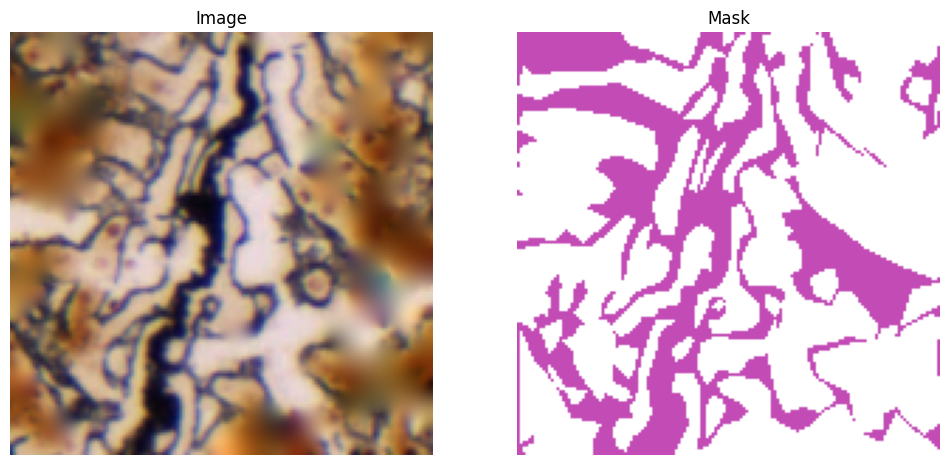

In [6]:
random_idx = random.randint(0, len(images)-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(images[random_idx])
axes[0].set_title("Image")
axes[0].axis('off')
axes[1].imshow(masks[random_idx], cmap="gray")
axes[1].set_title("Mask")
axes[1].axis('off')
plt.show()

print(len(images) == len(masks))

In [7]:
print(len(masks))

True
60


In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import keras
import numpy as np
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [9]:
def get_current_time_str():
  from datetime import datetime

  # Get current time
  now = datetime.now()

  # Some options:
  #  - "%Y-%m-%d %H:%M:%S"  # Year-Month-Day Hour:Minute:Second (e.g., 2024-04-04 15:49:23)
  #  - "%d/%m/%Y %H:%M:%S"  # Day/Month/Year Hour:Minute:Second (e.g., 04/04/2024 15:49:23)
  #  - "%H:%M:%S"          # Hour:Minute:Second (e.g., 15:49:23)
  time_string = now.strftime("%Y%m%d-%H:%M")

  return time_string


In [10]:
# If GPU is available, otherwise comment this section
from tensorflow.python.client import device_lib
import tensorflow as tf

print(device_lib.list_local_devices())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5949365790967888869
xla_global_id: -1
]
Num GPUs Available: 0


In [11]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name=None, dtype=None))
    # model.compile(optimizer = 'adam', loss = [jaccard_coef_loss], metrics = [jaccard_coef])

    model.summary()

    return model

In [12]:
# Load train images and masks here
train_images = images
train_masks = masks

# Preprocess your data as needed (e.g., normalization, resizing)
def preprocess_images(image_list, new_size):
    preprocessed_images = []
    for img in image_list:
        # Resize image
        resized_img = cv2.resize(img, new_size)

        # Normalize pixel values to the range [0, 1]
        normalized_img = resized_img.astype(np.float64) / 255
        preprocessed_images.append(normalized_img)

    return preprocessed_images

train_images = preprocess_images(train_images, (256, 256))
train_masks = preprocess_images(train_masks, (256, 256))

# Stack the lists of arrays into single arrays with an additional dimension
train_images_stacked = np.stack(train_images)
train_masks_stacked = np.stack(train_masks)

# print(type(train_masks_stacked[0]))
# print(type(train_images_stacked[0]))

print(train_masks_stacked[0].dtype)
print(train_images_stacked[0].dtype)

print(train_masks_stacked[0])
print(train_images_stacked[0])

# Checking images and masks shape
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

float64
float64
[[[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]
  ...
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]
  [0.76470588 0.29411765 0.71372549]]

 [[1.         1.         1.        ]
  [1.         1.     

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images_stacked, train_masks_stacked, test_size = 0.20, random_state = 0)

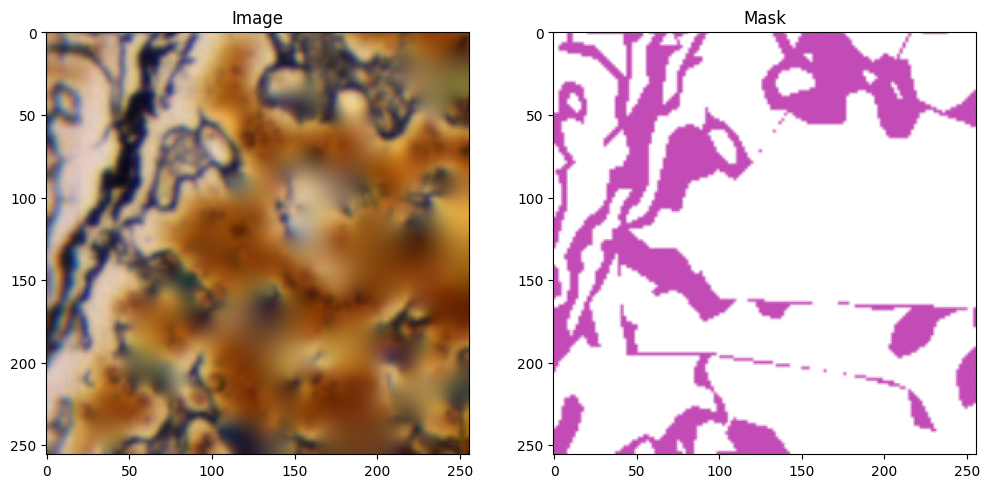

In [14]:
import random
import numpy as np
image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.title("Image")
plt.subplot(122)
plt.imshow(y_train[image_number])
plt.title("Mask")
plt.show()

In [15]:
# Show all images and corresponding masks
# import random
# import numpy as np
# for image_number in range(0, len(X_train)-1):
#   plt.figure(figsize=(12, 6))
#   plt.subplot(121)
#   plt.imshow(X_train[image_number])
#   plt.title("Image")
#   plt.subplot(122)
#   plt.imshow(y_train[image_number])
#   plt.title("Mask")
#   plt.show()

In [16]:
# Getting input parameters for U-Net
IMG_HEIGHT = train_images_stacked.shape[1]
IMG_WIDTH  = train_images_stacked.shape[2]
IMG_CHANNELS = train_images_stacked.shape[3]
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

256 256 3


In [17]:
def get_unet_model():
    return unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

unet_model = get_unet_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [18]:
NUM_EPOCHS = 50
BATCH_SIZE = 5

history_model = unet_model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs=NUM_EPOCHS,
                    validation_data=(X_test, y_test),
                    shuffle=True)

Epoch 1/50
10/10 [==============================] - 58s 5s/step - loss: 0.4686 - binary_io_u: 0.6493 - val_loss: 0.3400 - val_binary_io_u: 0.6201
Epoch 2/50
10/10 [==============================] - 52s 5s/step - loss: 0.2776 - binary_io_u: 0.7131 - val_loss: 0.3299 - val_binary_io_u: 0.6201
Epoch 3/50
10/10 [==============================] - 38s 4s/step - loss: 0.2617 - binary_io_u: 0.7131 - val_loss: 0.3084 - val_binary_io_u: 0.6201
Epoch 4/50
10/10 [==============================] - 40s 4s/step - loss: 0.2502 - binary_io_u: 0.7131 - val_loss: 0.3020 - val_binary_io_u: 0.6201
Epoch 5/50
10/10 [==============================] - 41s 4s/step - loss: 0.2429 - binary_io_u: 0.7132 - val_loss: 0.2979 - val_binary_io_u: 0.6201
Epoch 6/50
10/10 [==============================] - 39s 4s/step - loss: 0.2380 - binary_io_u: 0.7133 - val_loss: 0.2940 - val_binary_io_u: 0.6201
Epoch 7/50
10/10 [==============================] - 43s 4s/step - loss: 0.2318 - binary_io_u: 0.7144 - val_loss: 0.2880 - va

In [19]:
y_train.shape

(48, 256, 256, 3)

In [20]:
model_output_path = '/content/unet_ECM_final_50epochs_white_places.keras'
# print(os.path.exists(model_output_path))

unet_model.save(model_output_path)

In [21]:
 print(history_model.history.keys())
 keys_list = list(history_model.history.keys())

dict_keys(['loss', 'binary_io_u', 'val_loss', 'val_binary_io_u'])


In [22]:
loss_values = history_model.history['loss']
iou_values = history_model.history['binary_io_u']
val_loss_values = history_model.history['val_loss']
val_iou_values = history_model.history['val_binary_io_u']

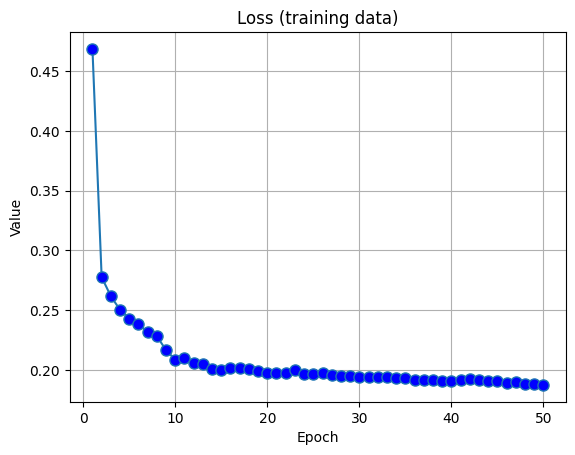

In [23]:
# Epochs (assuming they start from 1)
epochs = range(1, len(loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, loss_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Loss (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

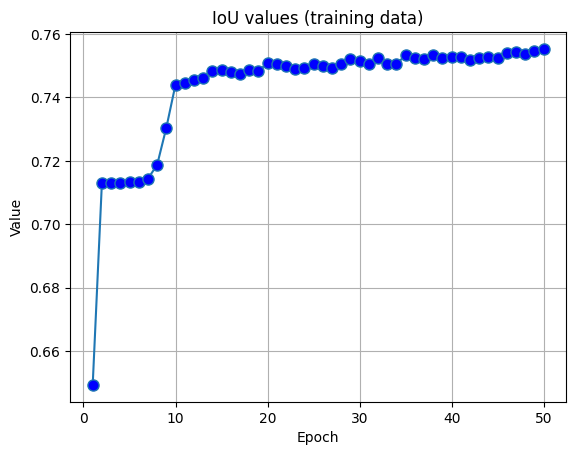

In [24]:
# Epochs (assuming they start from 1)
epochs = range(1, len(iou_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the Jaccard coeff values vs epochs
plt.plot(epochs, iou_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("IoU values (training data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

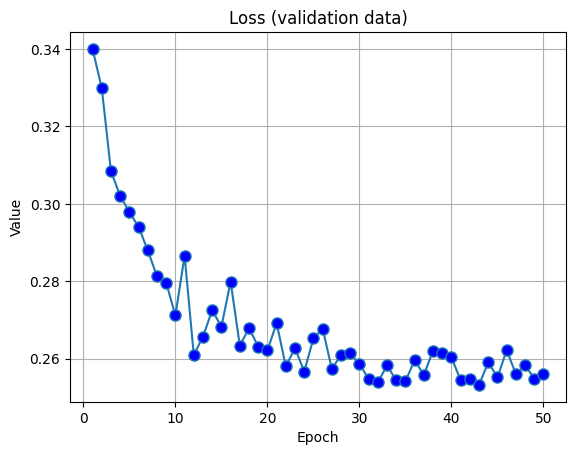

In [25]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_loss_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the loss values vs epochs
plt.plot(epochs, val_loss_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("Loss (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

plt.grid(True)
plt.show()

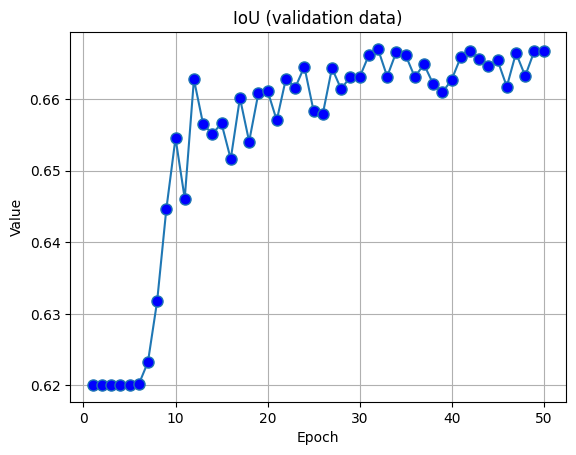

In [26]:
# Epochs (assuming they start from 1)
epochs = range(1, len(val_iou_values) + 1)  # Creates a sequence from 1 to the number of loss values

# Plot the Jaccard coeff values vs epochs
plt.plot(epochs, val_iou_values, '-o', markersize=8, markerfacecolor='blue')

plt.title("IoU (validation data)")
plt.xlabel("Epoch")
plt.ylabel("Value")

# Show the plot
plt.grid(True)
plt.show()

### Inference

In [27]:
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

my_model = load_model(model_output_path)

In [28]:
images_path = '/content/images/'
images_list = os.listdir('/content/images/')
print(len(images_list))

6930


In [29]:
# for image in images_list:
#   img_path = os.path.join(images_path, image)
#   img = load_img(img_path, target_size=(my_model.input_shape[1:3]))  # Match model input size
#   x = img_to_array(img)
#   x = x / 255.0  # Assuming model expects normalized values (0-1)
#   x = np.expand_dims(x, axis=0)

#   # Get segmentation mask
#   mask = my_model.predict(x)
#   mask = np.squeeze(mask, axis=0)
#   # Thresholding output mask
#   # threshold = 0.95  # You can adjust this value based on your needs
#   # mask = (mask[..., 0] > threshold).astype(np.uint8)  # Assuming channel 0 and converting to uint8 for binary mask
#   # plt.imshow(mask, cmap="gray")
#   # plt.show()
#   # print(img_path)
#   # plt.figure(figsize=(12, 6))
#   # plt.subplot(121)
#   # plt.title("Image")
#   # plt.imshow(img)
#   # plt.subplot(122)
#   # plt.title("Segmentation")
#   # plt.imshow(mask, cmap='gray')
#   # plt.show()

In [30]:
for i in range(20):
  image_number = random.randint(0, len(images)-1)
  image = images_list[image_number]
  img_path = os.path.join(images_path, image)
  img = load_img(img_path, target_size=(my_model.input_shape[1:3]))  # Match model input size
  x = img_to_array(img)
  x = x / 255.0  # Assuming model expects normalized values (0-1)
  x = np.expand_dims(x, axis=0)

  # Get segmentation mask
  mask = my_model.predict(x)
  mask = np.squeeze(mask, axis=0)
  # Thresholding output mask
  # threshold = 0.95  # You can adjust this value based on your needs
  # mask = (mask[..., 0] > threshold).astype(np.uint8)  # Assuming channel 0 and converting to uint8 for binary mask
  plt.figure(figsize=(12, 6))
  plt.subplot(121)
  plt.title("Image")
  plt.imshow(img)
  plt.subplot(122)
  plt.title("Segmentation")
  plt.imshow(mask, cmap='gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

1/1 [==============================] - 0s 306ms/step


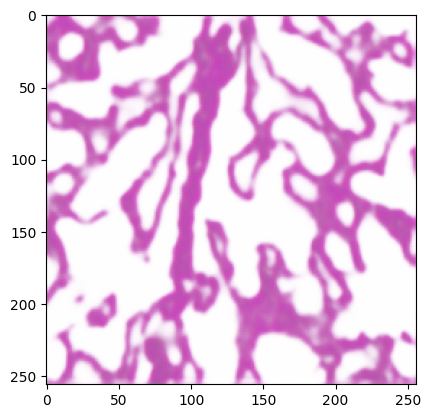

(256, 256, 3)


In [31]:
img_path = os.path.join(images_path, "0k0kwpq3.png")
img = load_img(img_path, target_size=(my_model.input_shape[1:3]))  # Match model input size
x = img_to_array(img)
x = x / 255.0  # Assuming model expects normalized values (0-1)
x = np.expand_dims(x, axis=0)

# Get segmentation mask
mask = my_model.predict(x)
mask = np.squeeze(mask, axis=0)
plt.imshow(mask, cmap="gray")
plt.show()
print(mask.shape)